## Load libraries

In [1]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.5
1.0.2


## define colors

In [2]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

# Section 3.1

Build a model that generates Poisson counts

## Build a generative model

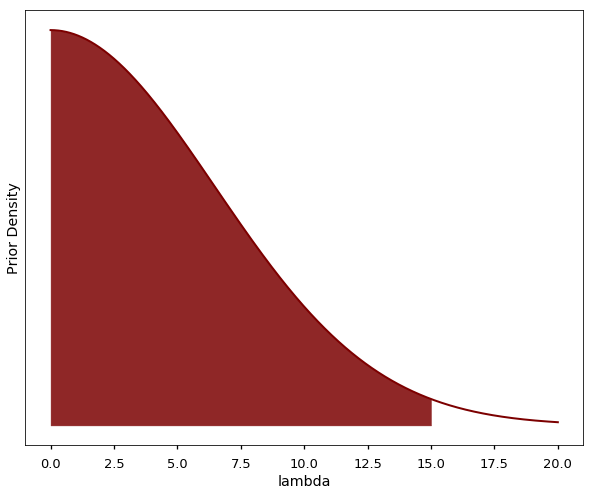

In [3]:
lbda  = np.linspace(0, 20, num=int(20/0.001))

plt.plot(lbda, stats.norm(loc=0,scale=6.44787).pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);


lbda99 = np.linspace(0, 15, num=int(15/0.001))



plt.fill_between(lbda99,0.,y2=stats.norm(loc=0,scale=6.44787).pdf(lbda99),color=c_dark)

In [4]:
#WORKING

model = pm.Model()
N = 1000
R = 500
with model:
    lbda = pm.HalfNormal("lbda",sd=6.44787)
    
    y = pm.Poisson("y",mu=lbda,shape=(N,),observed=None)
    

In [6]:
with model:
    trace = pm.sample_prior_predictive(samples=R)

In [7]:
simu_lbdas = trace['lbda']
simu_ys = trace['y']

## Plot prior predictive distribution

In [15]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

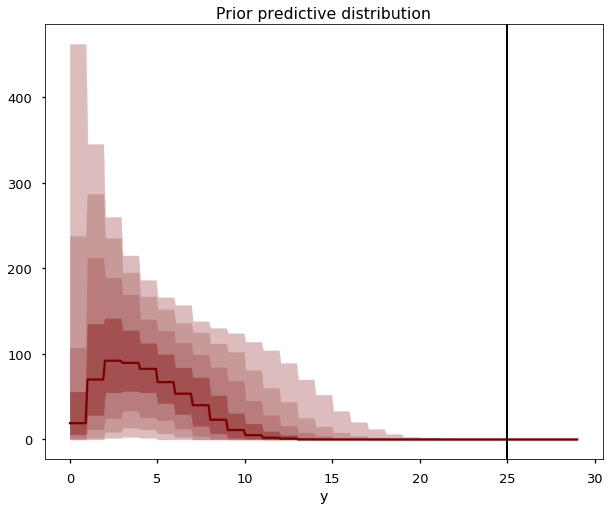

In [17]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

## Fit to simulated data

In example Betancourt performs this for each `y` in trace. Here we just do it for one.

In [55]:
model = pm.Model()
with model:
    lbda = pm.HalfNormal("lbda",sd=6.44787)
    
    y = pm.Poisson("y",mu=lbda,shape=(N,),observed=simu_ys[-1,:])
    
    trace = pm.sample(draws=R,tune=4*R)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lbda]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2450.38draws/s]


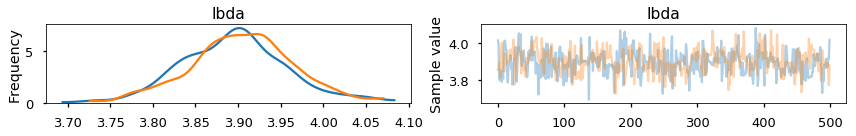

In [21]:
pm.plots.traceplot(trace);

In [38]:
# Compute rank of prior draw with respect to thinned posterior draws
sbc_rank = np.sum(simu_lbdas < trace['lbda'][::2])



(500,)

In [33]:
# posterior sensitivities analysis
s = pm.stats.summary(trace,varnames=['lbda'])
post_mean_lbda = s['mean'].values
post_sd_lbda = s['sd'].values
prior_sd_lbda = 6.44787
z_score = np.abs((post_mean_lbda - simu_lbdas) / post_sd_lbda)
shrinkage = 1 - (post_sd_lbda / prior_sd_lbda ) ** 2

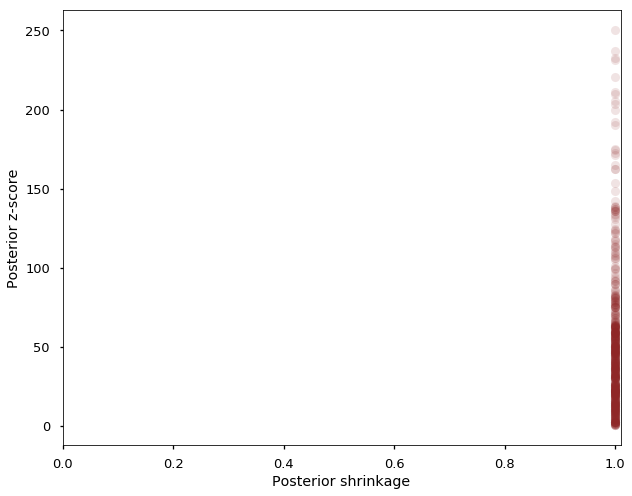

In [42]:
plt.plot(shrinkage[0]*np.ones(len(z_score)),z_score,'o',c="#8F272720");
plt.xlim(0,1.01); plt.xlabel('Posterior shrinkage'); plt.ylabel('Posterior z-score');

## Fit observations and evaluate

In [51]:
df = pd.read_csv('data.csv')
data_ys = df[df['data']=='y']['value'].values

In [56]:
model = pm.Model()
with model:
    lbda = pm.HalfNormal("lbda",sd=6.44787)
    
    y = pm.Poisson("y",mu=lbda,shape=(N,),observed=data_ys)
    
    trace = pm.sample(draws=R,tune=4*R,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [lbda]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1684.30draws/s]


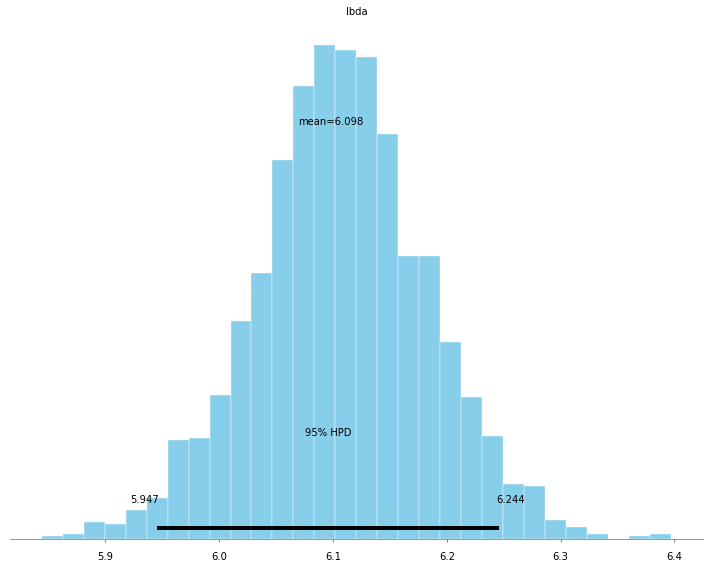

In [59]:
pm.plots.plot_posterior(trace,varnames=['lbda']);

In [60]:
with model:
     ppc = pm.sample_ppc(trace)

100%|██████████| 500/500 [00:00<00:00, 1507.74it/s]


In [72]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

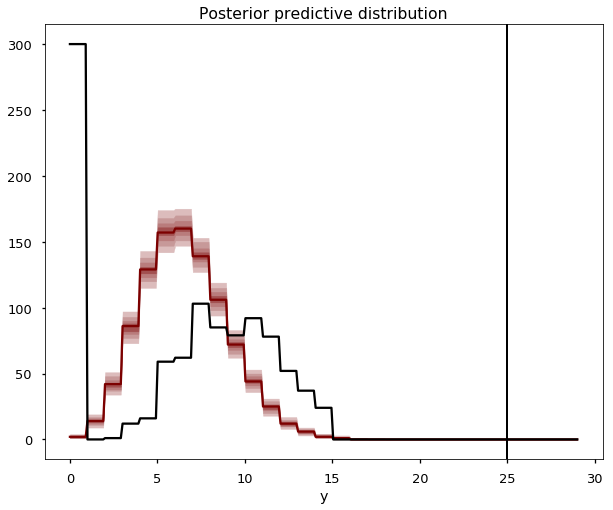

In [76]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');

# Section 3.2

In [3]:
generative_ensemble2 = pm.Model()

N = 1000
R = 1000

with generative_ensemble2:
    theta = pm.Beta(name="theta", alpha = 1, beta = 1)
    lambda_ = pm.HalfNormal(name="lambda", sd = 6.44787)
    y = pm.ZeroInflatedPoisson(name = "y", psi = theta, theta = lambda_, shape = (N,))

In [4]:
with generative_ensemble2:
    trace = pm.sample_prior_predictive(samples=R)

In [5]:
trace["theta"][:10]

array([0.93332145, 0.7714699 , 0.86558357, 0.86497487, 0.60348962,
       0.74533668, 0.72284839, 0.03031713, 0.79020511, 0.34467172])

In [6]:
trace["lambda"][:10]

array([11.79980369,  0.07890616,  7.9198449 ,  4.02674117,  0.64993403,
        1.55746614,  3.21968629,  2.54351671,  0.94194133,  1.09817687])

In [7]:
simu_ys = trace["y"]
simu_ys

array([[ 0,  0,  0, ...,  6,  0,  0],
       [ 0,  0,  0, ...,  5,  1, 11],
       [ 0,  0,  0, ...,  7,  3,  6],
       ...,
       [ 0,  0,  0, ...,  5,  3, 16],
       [ 0,  0,  0, ...,  5,  0,  6],
       [ 0,  0,  0, ...,  7,  1, 11]])

In [8]:
np.count_nonzero(simu_ys, axis=0).std()

285.0109788692358

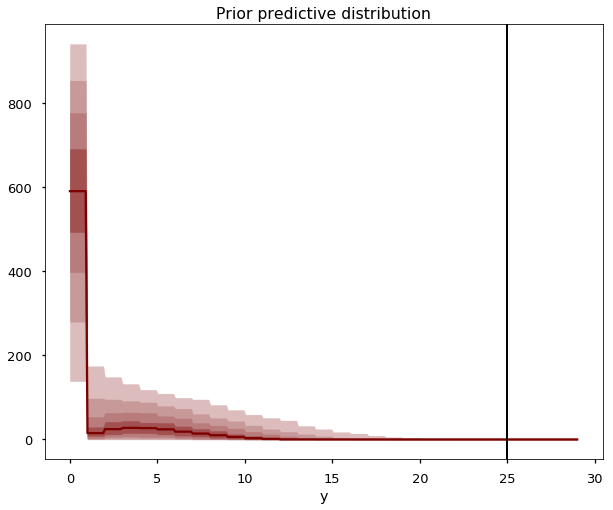

In [9]:
x_max = 30
bins = np.arange(0 ,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)

hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys.T)

prctiles = np.percentile(hists,np.linspace(10, 90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)



for i, color in enumerate([c_light, c_light_highlight, c_mid, c_mid_highlight]):
    plt.fill_between(bin_interp, prctiles_interp[i, :],
                     prctiles_interp[-1 - i, :],
                     alpha = 1.0,
                     color = color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

In [10]:
simu_ys[simu_ys > 25].size / simu_ys.size

0.000609

## Fit Simulated Observations and Evaluate 

In [27]:
fit_data2 = pm.Model()

N = 1000
R = 1000

with fit_data2:
    theta = pm.Beta(name="theta", alpha = 1, beta = 1)
    lambda_ = pm.HalfNormal(name="lambda", sd = 6.44787)
    y = pm.ZeroInflatedPoisson(name = "y", 
                               psi = theta, 
                               theta = lambda_, 
                               shape = (N,),
                               observed=simu_ys[-1,:])

In [28]:
with fit_data2:
    trace_fit = pm.sample(R)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3320.34draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf6a29acc0>,
      dtype=object)

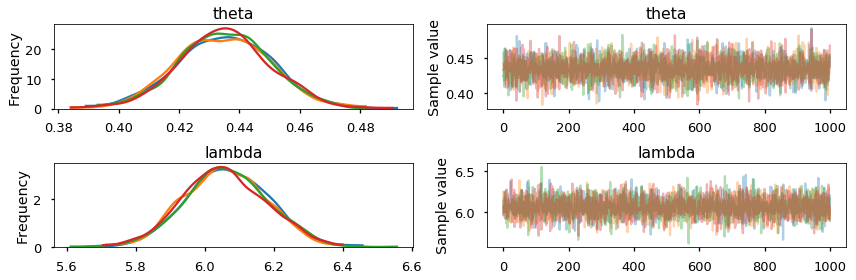

In [29]:
pm.plots.traceplot(trace_fit)

In [30]:
pm.summary(trace_fit, varnames=["theta", "lambda"]).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.43,0.02,0.0,0.41,0.46,4174.79,1.0
lambda,6.06,0.12,0.0,5.83,6.29,4191.15,1.0


In [20]:
import pickle
with open("fit_data2.pkl", "wb+") as buffer:
    pickle.dump({"model": fit_data2, "trace": trace_fit}, buffer)

# Section 3.3

Build a model that generates zero-inflated Poisson counts

## Build a generative model

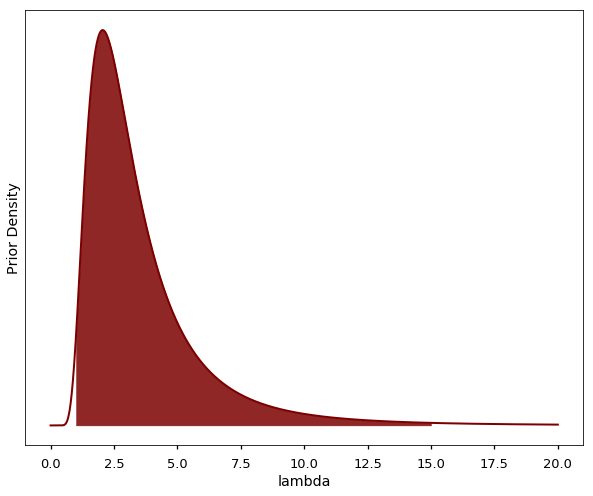

In [3]:
lbda  = np.linspace(0, 20, num=int(20/0.001))
pdf = stats.invgamma(3.48681,scale=9.21604)
plt.plot(lbda, pdf.pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);


lbda99 = np.linspace(1, 15, num=int(15/0.001))



plt.fill_between(lbda99,0.,y2=pdf.pdf(lbda99),color=c_dark)

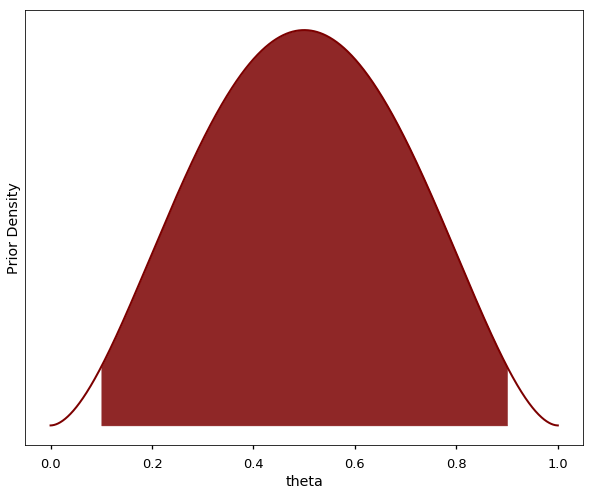

In [4]:
theta  = np.linspace(0, 1, num=int(1/0.001))
pdf = stats.beta(2.8663,2.8663)
plt.plot(theta, pdf.pdf(theta), c=c_dark_highlight, lw=2)
plt.xlabel("theta"); plt.ylabel("Prior Density"); plt.yticks([]);


theta99 = np.linspace(0.1, 0.9, num=int(0.8/0.001))



plt.fill_between(theta99,0.,y2=pdf.pdf(theta99),color=c_dark)

In [66]:
#WORKING

model = pm.Model()
N = 1000
R = 1000
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    theta = pm.Beta("theta",alpha=2.8663,beta=2.8663)
    
    y = pm.ZeroInflatedPoisson("y",psi=theta,theta=lbda,shape=N)
    

In [67]:
# Note this breaks when N != R
with model:
    trace = pm.sample_prior_predictive(samples=R)

In [68]:
simu_lbdas = trace['lbda']
simu_thetas = trace['theta']
simu_ys = trace['y']

## Plot prior predictive distribution

In [74]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

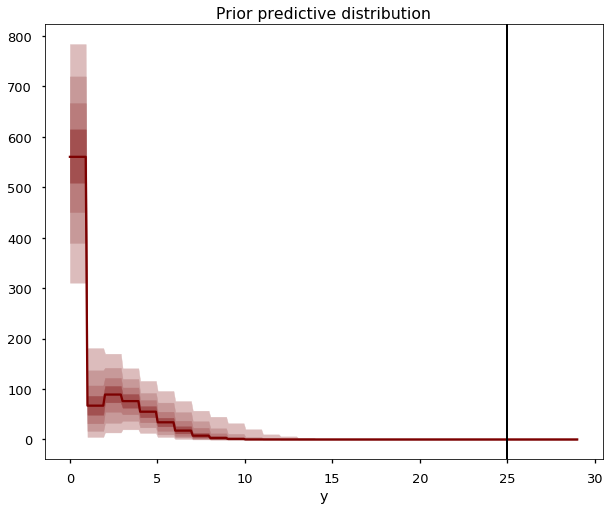

In [76]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

## Fit to simulated data

In example Betancourt performs this for each `y` in trace. Here we just do it for one.

In [80]:
model = pm.Model()
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    theta = pm.Beta("theta",alpha=2.8663,beta=2.8663)
    
    y = pm.ZeroInflatedPoisson("y",psi=theta,theta=lbda,shape=N,observed=simu_ys[:,-1])
    
    trace = pm.sample(draws=R,tune=4*R)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lbda]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1599.00draws/s]


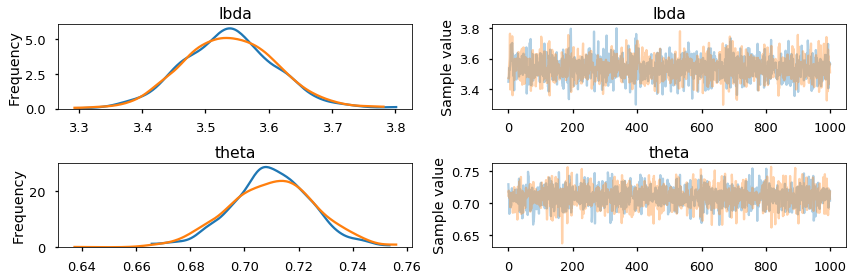

In [81]:
pm.plots.traceplot(trace);

In [82]:
# Compute rank of prior draw with respect to thinned posterior draws
sbc_rank = np.sum(simu_lbdas < trace['lbda'][::2])



In [83]:
# posterior sensitivities analysis
s = pm.stats.summary(trace,varnames=['lbda'])
post_mean_lbda = s['mean'].values
post_sd_lbda = s['sd'].values
prior_sd_lbda = 6.44787
z_score = np.abs((post_mean_lbda - simu_lbdas) / post_sd_lbda)
shrinkage = 1 - (post_sd_lbda / prior_sd_lbda ) ** 2

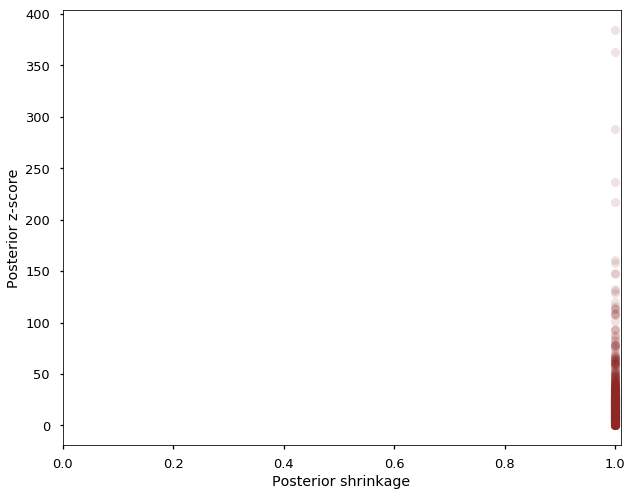

In [84]:
plt.plot(shrinkage[0]*np.ones(len(z_score)),z_score,'o',c="#8F272720");
plt.xlim(0,1.01); plt.xlabel('Posterior shrinkage'); plt.ylabel('Posterior z-score');

## Fit observations and evaluate

In [68]:
df = pd.read_csv('data.csv')
data_ys = df[df['data']=='y']['value'].values

In [86]:
model = pm.Model()
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    theta = pm.Beta("theta",alpha=2.8663,beta=2.8663)
    
    y = pm.ZeroInflatedPoisson("y",psi=theta,theta=lbda,shape=N,observed=data_ys)
    
    trace = pm.sample(draws=R,tune=4*R,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta, lbda]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:12<00:00, 1581.64draws/s]


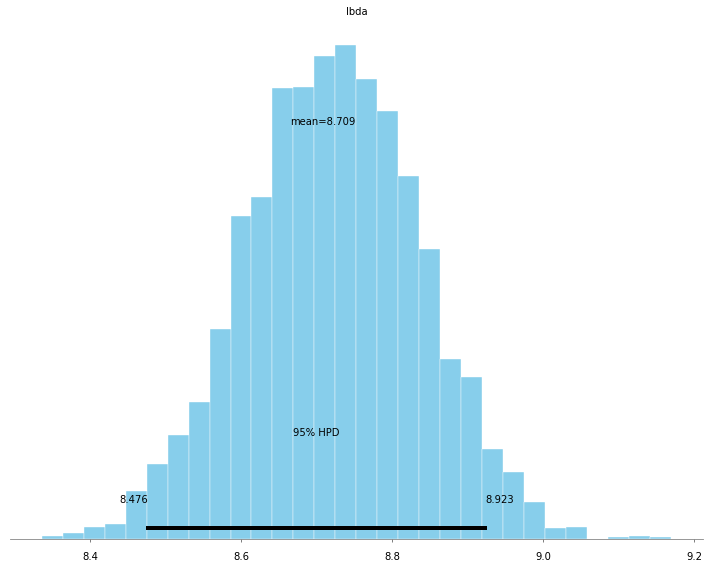

In [87]:
pm.plots.plot_posterior(trace,varnames=['lbda']);

In [88]:
with model:
     ppc = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:00<00:00, 1262.27it/s]


In [90]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

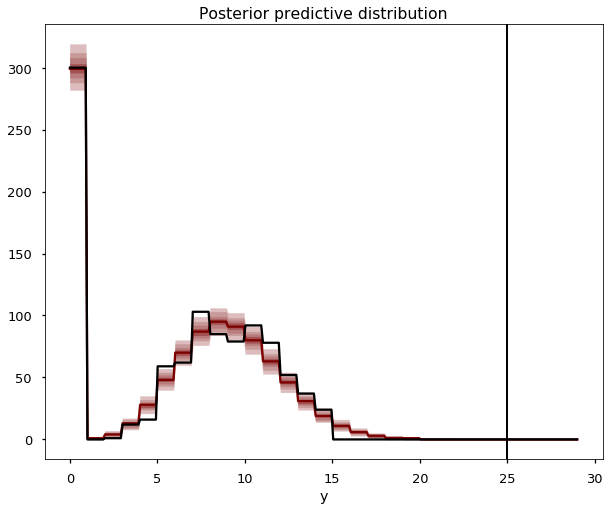

In [91]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');

# Section 3.4

In [60]:
from pymc3.distributions.distribution import generate_samples,draw_values,Discrete
from pymc3.distributions.discrete import Poisson

def rv_truncated_poisson(mu,mx, size=None):
    mu = np.asarray(mu)
    mx = np.asarray(mx)
    dist = stats.distributions.poisson(mu)

    lower_cdf = 0.
    upper_cdf = dist.cdf(mx)
    nrm = upper_cdf - lower_cdf
    sample = np.random.random_sample(size) * nrm + lower_cdf

    return dist.ppf(sample)

class TruncatedZeroInflatedPoisson(Discrete):

    def __init__(self, mu, mx, psi, *args, **kwargs):
        super(TruncatedZeroInflatedPoisson, self).__init__(*args, **kwargs)
        self.mu  = tt.as_tensor_variable(mu)
        self.mx = tt.as_tensor_variable(mx)
        self.psi = tt.as_tensor_variable(psi)
        self.mode = tt.floor(mu).astype('int32')


    def random(self, point=None, size=None):
        mu, psi, mx = draw_values([self.mu, self.psi, self.mx], point=point, size=size)
        g = generate_samples(rv_truncated_poisson, mu,mx,
                             dist_shape=self.shape,
                             size=size)
        return g * (np.random.random(np.squeeze(g.shape)) < psi)

    def logp(self, value):
        psi = self.psi
        mu = self.mu
        mx = self.mx
        poisson = pm.Poisson.dist(mu)
        logp_val = tt.switch(
            tt.gt(value, 0),
            tt.log(psi) + poisson.logp(value),
            pm.math.logaddexp(tt.log1p(-psi), tt.log(psi) - mu))

        return pm.distributions.dist_math.bound(
            logp_val,
            0 <= value,
            value <= mx,
            0 <= psi, psi <= 1,
            0 <= mu)

In [62]:
model = pm.Model()
N = 1000
R = 1000
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    psi = pm.Beta("psi",alpha=2.8663,beta=2.8663)
    
    y = TruncatedZeroInflatedPoisson("y",psi=psi,mu=lbda,mx=15.,shape=N)

In [63]:
with model:
    trace = pm.sample_prior_predictive(samples=1000)

In [65]:
simu_lbdas = trace['lbda']
simu_thetas = trace['psi']
simu_ys = trace['y']

In [66]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

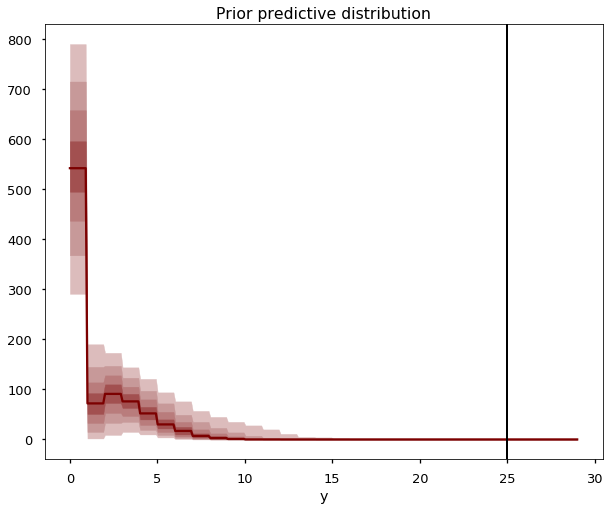

In [67]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

In [74]:
model = pm.Model()
N = 1000
R = 1000
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    psi = pm.Beta("psi",alpha=2.8663,beta=2.8663)
    
    y = TruncatedZeroInflatedPoisson("y",psi=psi,mu=lbda,mx=14.,shape=N,observed=data_ys)
    trace = pm.sample(draws=R,tune=4*R,chains=4)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, lbda]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:13<00:00, 1485.98draws/s]


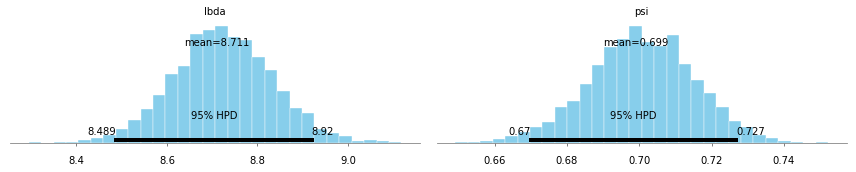

In [78]:
pm.plots.plot_posterior(trace);

In [75]:
with model:
     ppc = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:06<00:00, 143.41it/s]


In [76]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

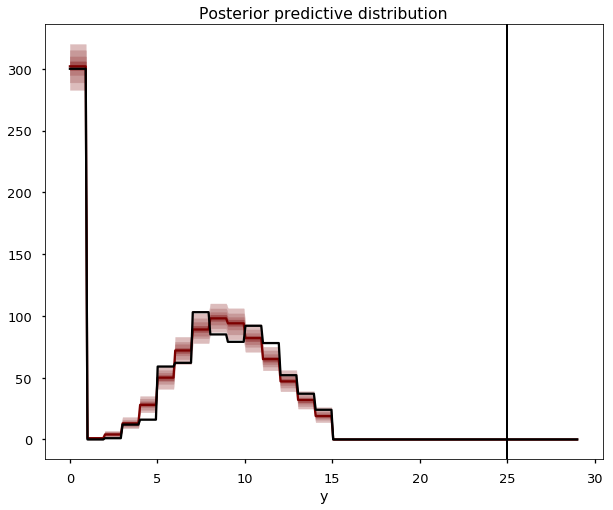

In [77]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');